In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from tqdm import tqdm
from scipy.io import wavfile
import os
import pandas as pd

from enfify.preprocessing import ffmpeg_filenames_cut, cut_audio, bandpass_filter
from enfify.enf_estimation import segmented_phase_estimation_hilbert_new, segmented_freq_estimation_DFT1, segmented_phase_estimation_DFT1, STFT

In [2]:
def func_ENF_synthesis_corrupted_harmonic(fundamental_f, harmonic_index, corrupted_index, duration, fs, corrupt):
    N = int(duration * fs)
    
    # Create fundamental IF
    f0 = np.random.randn(N)
    IF0 = np.cumsum(f0) * 0.0005
    IF0 = IF0 / np.std(IF0) * np.sqrt(4.5e-4)
    IF0 = IF0 + fundamental_f
    IFs = np.outer(harmonic_index, IF0)  # IFs across all harmonics
    
    if corrupt == True:
        index = np.intersect1d(harmonic_index, corrupted_index) - 1
        for i in range(len(index)):
            IFs[index[i], :] = IFs[index[i], :] + 5 * np.random.randn(N)

    # Instantaneous amplitudes and initial phases
    N_harmonic = len(harmonic_index)
    amps = 1 + np.random.randn(N_harmonic, N) * 0.005  # instantaneous amplitudes
    phases = np.random.uniform(0, 2 * np.pi, N_harmonic)  # initial phases

    # Synthesize time domain waveforms
    ENF_multi = np.zeros((N_harmonic, N))
    for n in tqdm(range(N)):
        ENF_multi[:, n] = amps[:, n] * np.cos(2 * np.pi / fs * np.sum(IFs[:, :n+1], axis=1) + phases)
    
    for i in range(min(6, N_harmonic)):
        ENF_multi[i, :] = ENF_multi[i, :] / np.linalg.norm(ENF_multi[i, :])

    raw_wave = np.sum(ENF_multi, axis=0)
    raw_wave_multi = ENF_multi
    raw_wave = raw_wave / np.linalg.norm(raw_wave)  # ensure unit norm

    return raw_wave, IF0, raw_wave_multi

def butter_bandpass_test(lowcut, highcut, fs, order=5, label=None):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = signal.butter(order, [low, high], btype='band', output='sos')
    w, h = signal.sosfreqz(sos,worN=20000)
    plt.semilogx((fs * 0.5 / np.pi) * w, abs(h), label=label)
    return sos

100%|██████████| 60000/60000 [00:02<00:00, 29059.12it/s] 


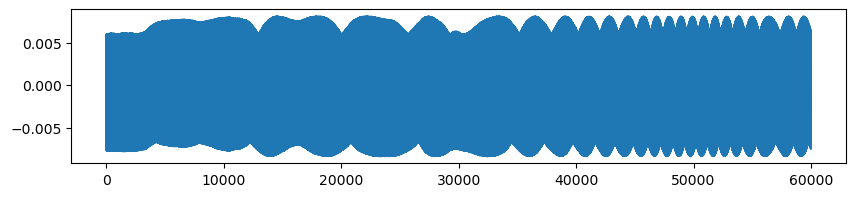

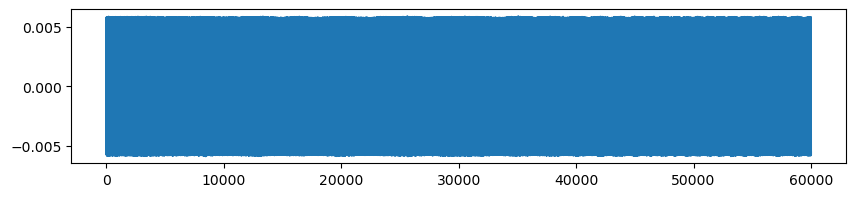

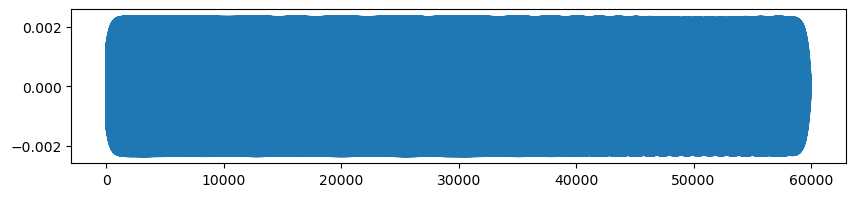

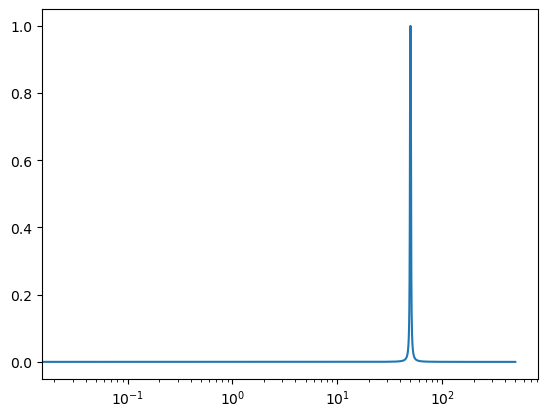

In [3]:
# Example
fundamental_f = 50  # ENF freq
harmonic_index = np.array([1, 2, 3, 4, 5, 6])
corrupted_index = np.array([2, 4, 6])
duration = 60  # in seconds
fs = 1000  # sampling freq

raw_wave, IF, raw_wave_multi = func_ENF_synthesis_corrupted_harmonic(fundamental_f, harmonic_index, corrupted_index, duration, fs, False)

plt.figure(figsize=(10,2))
plt.plot(raw_wave)
plt.show()

len(raw_wave_multi)
plt.figure(figsize=(10,2))
plt.plot(raw_wave_multi[0])
plt.show()

sig = bandpass_filter(raw_wave, 49.5, 50.5, fs, 1)

plt.figure(figsize=(10,2))
plt.plot(sig)
plt.show()

butter_test = butter_bandpass_test(49.5, 50.5, fs, order=2, label=None)

In [ ]:
def one_min_audio_alices(sig, fs):
    audio_len = len(sig)/fs  # Audio len in seconds

In [ ]:
fundamental_f = 50  # ENF freq
harmonic_index = np.array([1, 2, 3, 4, 5, 6])
corrupted_index = np.array([0, 0, 0])
duration = 10  # in seconds
fs = 1000  # sampling freq

for i in tqdm(range(1000)):

    # Generate 3 unique random integers between 2 and 6 (inclusive)
    random_numbers = np.random.choice(np.arange(2, 7), size=3, replace=False)
    corrupted_index[:] = random_numbers

    sig, freqs, sig_multi = func_ENF_synthesis_corrupted_harmonic(fundamental_f, harmonic_index, corrupted_index, duration, fs, False)

    wavfile.write('/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/raw/synthetic/uncut/audio/'+ str(i) +'_audio.wav', fs, sig)
    np.save('/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/raw/synthetic/uncut/freqs/'+ str(i) +'freqs.npy', freqs)
    np.save('/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/raw/synthetic/uncut/harmonics/' + str(i) + 'harmonics.npy', sig_multi)


In [ ]:
# Cut the synthetic signals

input_dir = "/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/raw/synthetic/uncut/audio"
output_dir = "/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/raw/synthetic/cut/audio"


files, cut_files = ffmpeg_filenames_cut(input_dir, output_dir)
cut_len = [np.random.randint(1, 19) for i in range(len(files))]
i_cut = [np.random.randint(20, 41) for i in range(len(files))]

for i in range(len(files)):
    cut_audio(files[i], cut_files[i], i_cut[i], (i_cut[i]+cut_len[i]))

In [3]:
# Synthetic Audio files into
cut_dir = '/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/raw/synthetic/cut/new_train_cut_audio'
uncut_dir = '/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/raw/synthetic/new_uncut/train'

file_list_uncut = os.listdir(uncut_dir)
file_list_cut = os.listdir(cut_dir)
fs = 1000
num_cycles = 10
nom_enf = 50
N_DFT = 20_000


uncut_sig_freqs = []
uncut_sig_phases = []
for wav_file in tqdm(file_list_uncut):
    file_path = os.path.join(uncut_dir, wav_file)
    fs, signal = wavfile.read(file_path)
    bandpass_sig = bandpass_filter(signal, 49.5, 50.5, fs, 1)
    phases = segmented_phase_estimation_hilbert(bandpass_sig, fs, num_cycles, nom_enf)
    freqs = segmented_freq_estimation_DFT1(bandpass_sig, fs, num_cycles, N_DFT, nom_enf)
    uncut_sig_freqs.append(freqs)
    uncut_sig_phases.append(phases)

cut_sig_freqs = []
cut_sig_phases = []
for wav_file in tqdm(file_list_cut):
    file_path = os.path.join(cut_dir, wav_file)
    fs, signal = wavfile.read(file_path)
    bandpass_sig = bandpass_filter(signal, 49.5, 50.5, fs, 1)
    phases = segmented_phase_estimation_hilbert(bandpass_sig, fs, num_cycles, nom_enf)
    freqs = c
    cut_sig_freqs.append(freqs)
    cut_sig_phases.append(phases)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [15:22<00:00,  1.08it/s]


In [4]:
freq_train_cut = cut_sig_freqs[:800]
freq_val_cut = cut_sig_freqs[800:900]
freq_test_cut = cut_sig_freqs[900:]

freq_train_uncut = uncut_sig_freqs[:800]
freq_val_uncut = uncut_sig_freqs[800:900]
freq_test_uncut = uncut_sig_freqs[900:]

In [5]:
phases_train_cut = cut_sig_phases[:800]
phases_val_cut = cut_sig_phases[800:900]
phases_test_cut = cut_sig_phases[900:]

phases_train_uncut = uncut_sig_phases[:800]
phases_val_uncut = uncut_sig_phases[800:900]
phases_test_uncut = uncut_sig_phases[900:]

In [16]:
# Freqs data label
pth = "/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/processed/Synthetic_Data/frequencies"

# Step 1: Create labels
freq_train_labels = np.concatenate([np.ones(len(freq_train_cut)), np.zeros(len(freq_train_uncut))])
freq_val_labels = np.concatenate([np.ones(len(freq_val_cut)), np.zeros(len(freq_val_uncut))])
freq_test_labels = np.concatenate([np.ones(len(freq_test_cut)), np.zeros(len(freq_test_uncut))])

# Step 2: Combine the data
freq_train_data = freq_train_cut + freq_train_uncut
freq_val_data = freq_val_cut + freq_val_uncut
freq_test_data = freq_test_cut + freq_test_uncut

# Step 3: Shuffle the data
train_indices = np.random.permutation(len(freq_train_data))
val_indices = np.random.permutation(len(freq_val_data))
test_indices = np.random.permutation(len(freq_test_data))

freq_train_data = np.array([freq_train_data[i] for i in train_indices], dtype=object)
freq_train_labels = freq_train_labels[train_indices]
np.save(pth + '/' + 'freq_train_data.npy', freq_train_data)
np.save(pth + '/' + 'freq_train_labels.npy', freq_train_labels)

freq_val_data = np.array([freq_val_data[i] for i in val_indices], dtype=object)
freq_val_labels = freq_val_labels[val_indices]
np.save(pth + '/' + 'freq_val_data.npy', freq_val_data)
np.save(pth + '/' + 'freq_val_labels.npy', freq_val_labels)

freq_test_data = np.array([freq_test_data[i] for i in test_indices], dtype=object)
freq_test_labels = freq_test_labels[test_indices]
np.save(pth + '/' + 'freq_test_data.npy', freq_test_data)
np.save(pth + '/' + 'freq_test_labels.npy', freq_test_labels)

In [17]:
# Phases data label
pth = '/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/processed/Synthetic_Data/phases'

# Step 1: Create labels
phases_train_labels = np.concatenate([np.ones(len(phases_train_cut)), np.zeros(len(phases_train_uncut))])
phases_val_labels = np.concatenate([np.ones(len(phases_val_cut)), np.zeros(len(phases_val_uncut))])
phases_test_labels = np.concatenate([np.ones(len(phases_test_cut)), np.zeros(len(phases_test_uncut))])

# Step 2: Combine the data
phases_train_data = phases_train_cut + phases_train_uncut
phases_val_data = phases_val_cut + phases_val_uncut
phases_test_data = phases_test_cut + phases_test_uncut

# Step 3: Shuffle the data
train_indices = np.random.permutation(len(phases_train_data))
val_indices = np.random.permutation(len(phases_val_data))
test_indices = np.random.permutation(len(phases_test_data))

phases_train_data = np.array([phases_train_data[i] for i in train_indices], dtype=object)
phases_train_labels = phases_train_labels[train_indices]
np.save(pth + '/' + 'phases_train_data.npy', phases_train_data)
np.save(pth + '/' + 'phases_train_labels.npy', phases_train_labels)

phases_val_data = np.array([phases_val_data[i] for i in val_indices], dtype=object)
phases_val_labels = phases_val_labels[val_indices]
np.save(pth + '/' + 'phases_val_data.npy', phases_val_data)
np.save(pth + '/' + 'phases_val_labels.npy', phases_val_labels)

phases_test_data = np.array([phases_test_data[i] for i in test_indices], dtype=object)
phases_test_labels = phases_test_labels[test_indices]
np.save(pth + '/' + 'phases_test_data.npy', phases_test_data)
np.save(pth + '/' + 'phases_test_labels.npy', phases_test_labels)

In [15]:
import numpy as np
import math

def extract_spatial_features(psi_1_list):
    """
    Function to extract spatial features S Fsn×sn from phase sequence features ψ1.
    
    Parameters:
    - psi_1_list: A list of phase sequence features (arrays) for multiple audio files.

    Returns:
    - spatial_features: A list of spatial feature matrices S Fsn×sn for each audio file.
    """

    # Calculate the longest phase across all audio files
    len_psi_DFT1 = max([len(psi_1) for psi_1 in psi_1_list])

    ML = math.ceil(len_psi_DFT1)
    sn = math.ceil(math.sqrt(ML))  # sn is the number of phase points per frame

    spatial_features = []

    for psi_1 in psi_1_list:
        current_len = len(psi_1)

        overlap = sn - math.ceil((ML - sn) / (current_len - sn))

        # Split the frame
        num_frames = (current_len - sn) // overlap + 1
        frames = []
        
        for i in range(0, num_frames * overlap, overlap):
            if i + sn <= current_len:
                frame = psi_1[i:i + sn]
                frames.append(frame)
            else:
                break

        # Reshape into a spatial feature matrix (S Fsn×sn)
        feature_matrix = np.zeros((sn, sn))

        for i in range(min(sn, len(frames))):
            feature_matrix[i, :len(frames[i])] = frames[i]

        spatial_features.append(feature_matrix)

    return spatial_features

def extract_spatial_features_new(psi_1_list, sn):
    """
    Function to extract spatial features S Fsn×sn from phase sequence features ψ1.
    
    Parameters:
    - psi_1_list: A list of phase sequence features (arrays) for multiple audio files.

    Returns:
    - spatial_features: A list of spatial feature matrices S Fsn×sn for each audio file.
    """

    ML = sn**2
    spatial_features = []

    for psi_1 in psi_1_list:
        current_len = len(psi_1)

        overlap = sn - math.ceil((ML - sn) / (current_len - sn))

        # Split the frame
        num_frames = (current_len - sn) // overlap + 1
        frames = []
        
        for i in range(0, num_frames * overlap, overlap):
            if i + sn <= current_len:
                frame = psi_1[i:i + sn]
                frames.append(frame)
            else:
                break

        # Reshape into a spatial feature matrix (S Fsn×sn)
        feature_matrix = np.zeros((sn, sn))

        for i in range(min(sn, len(frames))):
            feature_matrix[i, :len(frames[i])] = frames[i]

        spatial_features.append(feature_matrix)

    return spatial_features


def extract_temporal_features(psi_1_list, fl):
    """
    Function to extract temporal features T F fl × fn from phase sequence features ψ1.
    
    Parameters:
    - psi_1_list: A list of phase sequence features (arrays) for multiple audio files.
    - fl: The number of phase points contained in each frame (frame length).

    Returns:
    - temporal_features: A list of temporal feature matrices T F fl × fn for each audio file.
    """
    
    temporal_features = []
    
    # Calculate the maximum length (Mmax) across all phase sequences
    Mmax = max([len(psi_1) for psi_1 in psi_1_list])
    
    # Calculate the number of frames fn
    fn = Mmax // fl

    for psi_1 in psi_1_list:
        current_len = len(psi_1)

        overlap = fl - math.floor(current_len / fn)

        # Split the phase sequence into frames using the calculated overlap
        frames = []
        for i in range(0, current_len - fl + 1, overlap):
            frame = psi_1[i:i + fl]
            frames.append(frame)
        
        # Cases where the last frame is smaller than `fl`
        if len(psi_1) % fl != 0:
            frame = psi_1[-fl:] 
            frames.append(frame)

        # Reshape the frames into a temporal feature matrix T F fl × fn
        feature_matrix = np.zeros((fl, fn))

        # Matrix
        for i in range(min(fn, len(frames))):
            feature_matrix[:, i] = frames[i]

        temporal_features.append(feature_matrix)

    return temporal_features

def extract_temporal_features_new(psi_1_list, fl, fn):
    """
    Function to extract temporal features T F fl × fn from phase sequence features ψ1.
    
    Parameters:
    - psi_1_list: A list of phase sequence features (arrays) for multiple audio files.
    - fl: The number of phase points contained in each frame (frame length).

    Returns:
    - temporal_features: A list of temporal feature matrices T F fl × fn for each audio file.
    """
    
    temporal_features = []
    
    for psi_1 in psi_1_list:
        current_len = len(psi_1)

        overlap = fl - math.floor(current_len / fn)

        # Split the phase sequence into frames using the calculated overlap
        frames = []
        for i in range(0, current_len - fl + 1, overlap):
            frame = psi_1[i:i + fl]
            frames.append(frame)
        
        # Cases where the last frame is smaller than `fl`
        if len(psi_1) % fl != 0:
            frame = psi_1[-fl:] 
            frames.append(frame)

        # Reshape the frames into a temporal feature matrix T F fl × fn
        feature_matrix = np.zeros((fl, fn))

        # Matrix
        for i in range(min(fn, len(frames))):
            feature_matrix[:, i] = frames[i]

        temporal_features.append(feature_matrix)

    return temporal_features



In [37]:
# Synthetic Audio files phases
cut_dir = '/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/raw/synthetic/40s/cut/0_cut_audio.wav'
uncut_dir = '/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/raw/synthetic/40s/uncut/0_audio.wav'

fs_cut, sig_cut = wavfile.read(cut_dir)
fs_uncut, sig_uncut = wavfile.read(uncut_dir)

# Constants
lowcut = 49.5
highcut = 50.5
order = 1
down_sample_rate = 1000
nominal_enf = 50
N_DFT = 20_000

window_len = 200
step_size = 20

cut_band = bandpass_filter(sig_cut, lowcut, highcut, down_sample_rate, order)
uncut_band = bandpass_filter(sig_uncut, lowcut, highcut, down_sample_rate, order)

cut_freqs = STFT(cut_band, down_sample_rate, step_size, window_len)
cut_phases = segmented_phase_estimation_DFT1(cut_band, down_sample_rate, nominal_enf, N_DFT, step_size, window_len)
cut_phases_hil = segmented_phase_estimation_hilbert_new(cut_band, step_size, window_len)

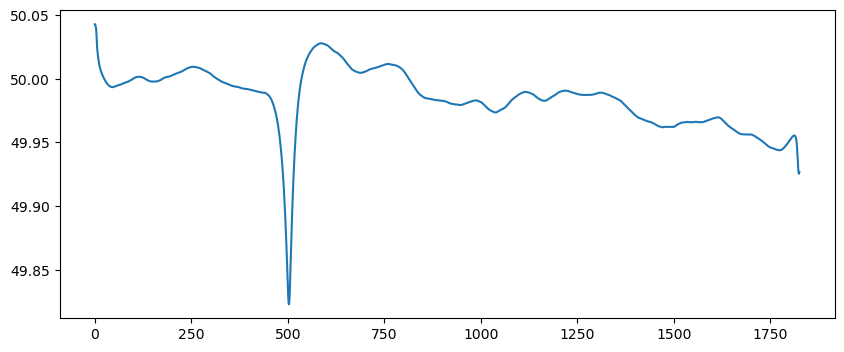

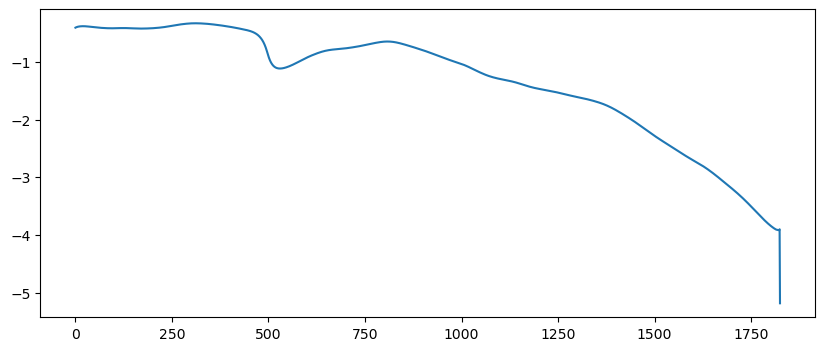

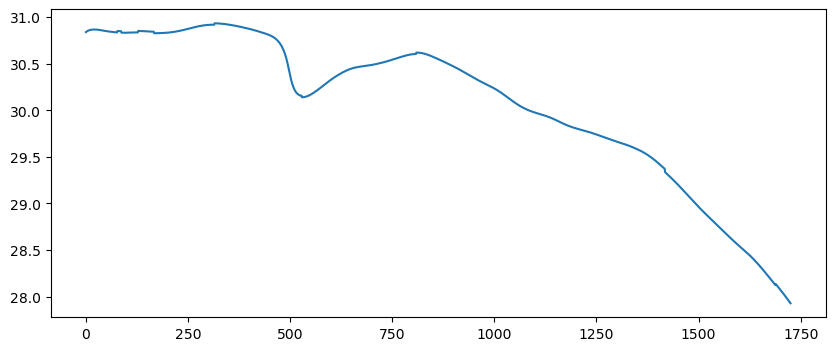

In [38]:
plt.figure(figsize=(10, 4))
plt.plot(cut_freqs)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(cut_phases)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(cut_phases_hil[:-100])
plt.show()

In [43]:
fl = 85
fn = 25
sn = 46

temporal_features = extract_temporal_features_new([cut_freqs], fl, fn)
spatial_features = extract_spatial_features_new([cut_freqs], sn)

print(np.shape(temporal_features[0]))
print(np.shape(spatial_features[0]))

(85, 25)
(46, 46)
